<a href="https://colab.research.google.com/github/sanjaydinesh19/lstm-footwear-analysis/blob/main/ML_Pipeline_Footwear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import joblib
import os
from google.colab import drive


In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.20
N_ESTIMATORS = 200
SAVE_MODEL = True
MODEL_PATH = "rf_units_sold_model.joblib"
drive.mount("/content/drive")
CSV_PATH = "/content/drive/MyDrive/Research/Time Series Footwear/data.csv"

Mounted at /content/drive


In [7]:
df = pd.read_csv(CSV_PATH)
data = df.copy()

In [8]:
if 'week_end_date' in data.columns:
    try:
        data['week_end_date'] = pd.to_datetime(data['week_end_date'])
        # Engineered Features
        data['week_day'] = data['week_end_date'].dt.weekday
        data['week_of_year'] = data['week_end_date'].dt.isocalendar().week.astype(int)
        # Drop Original Date
        data = data.drop(columns=['week_end_date'])
    except Exception:
        # If parsing fails, drop the column
        data = data.drop(columns=['week_end_date'])

In [10]:
#Handle missing values
for col in data.columns:
    if data[col].isna().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col] = data[col].fillna(data[col].median())
        else:
            data[col] = data[col].fillna(data[col].mode().iloc[0])

In [11]:
# Convert boolean-like columns to integers if present
bool_candidates = ['promo_flag', 'is_festival_season']
for col in bool_candidates:
    if col in data.columns:
        # Common representations: True/False, 1/0, 'Y'/'N', 'yes'/'no'
        if data[col].dtype == object:
            data[col] = data[col].map({
                'Y': 1, 'N': 0, 'y': 1, 'n': 0,
                'yes': 1, 'no': 0, 'Yes': 1, 'No': 0,
                'true': 1, 'false': 0, 'True': 1, 'False': 0
            }).fillna(data[col])
        # finally convert to integer if possible
        if pd.api.types.is_bool_dtype(data[col]) or pd.api.types.is_integer_dtype(data[col]):
            data[col] = data[col].astype(int)

In [12]:
# Identify categorical columns (object dtype)
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Label encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

In [13]:
#Split Features and Target
TARGET = 'units_sold'
if TARGET not in data.columns:
    raise ValueError(f"Target column '{TARGET}' not found in data.")

X = data.drop(columns=[TARGET])
y = data[TARGET]

In [14]:
for col in X.columns:
    if not pd.api.types.is_numeric_dtype(X[col]):
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [16]:
model = RandomForestRegressor(
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [17]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Random Forest regression results:")
print(f"R² (accuracy): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Random Forest regression results:
R² (accuracy): 0.9953
Mean Absolute Error (MAE): 0.1156


In [18]:
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nTop feature importances:")
print(feat_importances.head(20).to_string())


Top feature importances:
revenue_inr                 0.622036
unit_price_inr              0.374572
neighborhood_trend_index    0.000581
rainfall_mm                 0.000539
avg_temp_c                  0.000520
week_of_year                0.000479
product_id                  0.000435
units_returned              0.000316
store_id                    0.000236
discount_rate               0.000117
is_festival_season          0.000093
promo_flag                  0.000075
week_day                    0.000000


In [19]:
if SAVE_MODEL:
    # Save model
    joblib.dump(model, MODEL_PATH)
    # Save label encoders and column order as a separate file
    encoders_path = "label_encoders_and_cols.joblib"
    joblib.dump({
        "label_encoders": label_encoders,
        "feature_columns": X.columns.tolist()
    }, encoders_path)
    print(f"\nModel saved to: {os.path.abspath(MODEL_PATH)}")
    print(f"Encoders & columns saved to: {os.path.abspath(encoders_path)}")


Model saved to: /content/rf_units_sold_model.joblib
Encoders & columns saved to: /content/label_encoders_and_cols.joblib


In [20]:
# Evaluate Train and Test Accuracy
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Compute accuracy as how close predictions are to true values (using Mean Absolute Percentage Accuracy)
train_accuracy = 100 * (1 - np.mean(np.abs((y_train - train_pred) / y_train)))
test_accuracy = 100 * (1 - np.mean(np.abs((y_test - test_pred) / y_test)))

print(f"Train Set Accuracy: {train_accuracy:.2f}%")
print(f"Test Set Accuracy:  {test_accuracy:.2f}%")


Train Set Accuracy: 99.77%
Test Set Accuracy:  99.38%


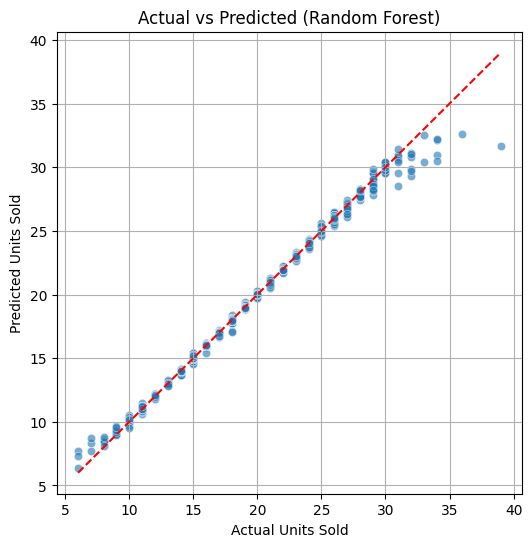

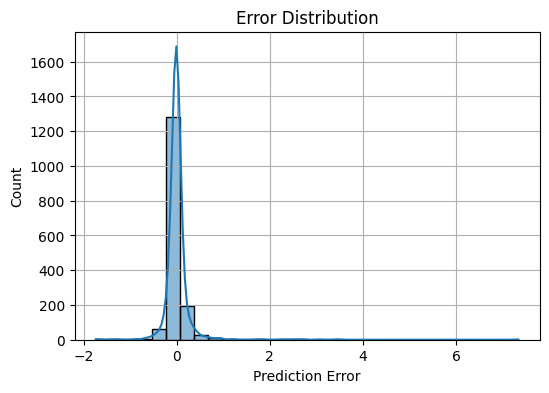

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Actual vs Predicted (Random Forest)")
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Prediction Error")
plt.title("Error Distribution")
plt.grid(True)
plt.show()

